In [52]:
import tensorflow as tf
import xml.etree.ElementTree as ET
import numpy as np
from matplotlib import pyplot as plt
import os 
import shutil
import random
import cv2

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.test.is_gpu_available()

False

In [9]:
tf.config.list_physical_devices('GPU')

[]

In [10]:
images = tf.data.Dataset.list_files('data/columnU/*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'data/columnU/postureIncorrect_679.jpg'

In [14]:
def load_image(x):
    bytes = tf.io.read_file(x)
    img = tf.image.decode_jpeg(bytes, channels=3)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[106,  99,  91],
        [105,  98,  90],
        [106,  96,  87],
        ...,
        [ 74,  68,  78],
        [ 73,  70,  79],
        [ 75,  72,  81]],

       [[106,  99,  91],
        [106,  99,  91],
        [106,  96,  87],
        ...,
        [ 70,  68,  73],
        [ 70,  68,  73],
        [ 70,  68,  73]],

       [[104,  97,  87],
        [106,  99,  89],
        [107,  97,  88],
        ...,
        [ 71,  70,  68],
        [ 71,  70,  68],
        [ 71,  71,  69]],

       ...,

       [[ 54,  73,  53],
        [ 53,  72,  52],
        [ 54,  73,  54],
        ...,
        [ 99, 106,  98],
        [ 98, 105,  97],
        [100, 107,  99]],

       [[ 54,  67,  50],
        [ 54,  67,  50],
        [ 55,  69,  52],
        ...,
        [ 96, 108,  98],
        [ 93, 106,  96],
        [ 92, 105,  95]],

       [[ 50,  61,  45],
        [ 52,  63,  47],
        [ 54,  67,  50],
        ...,
        [ 94, 107,  97],
        [ 88, 104,  93],
        [ 85, 101,  90]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [24]:
plot_images = image_generator.next()

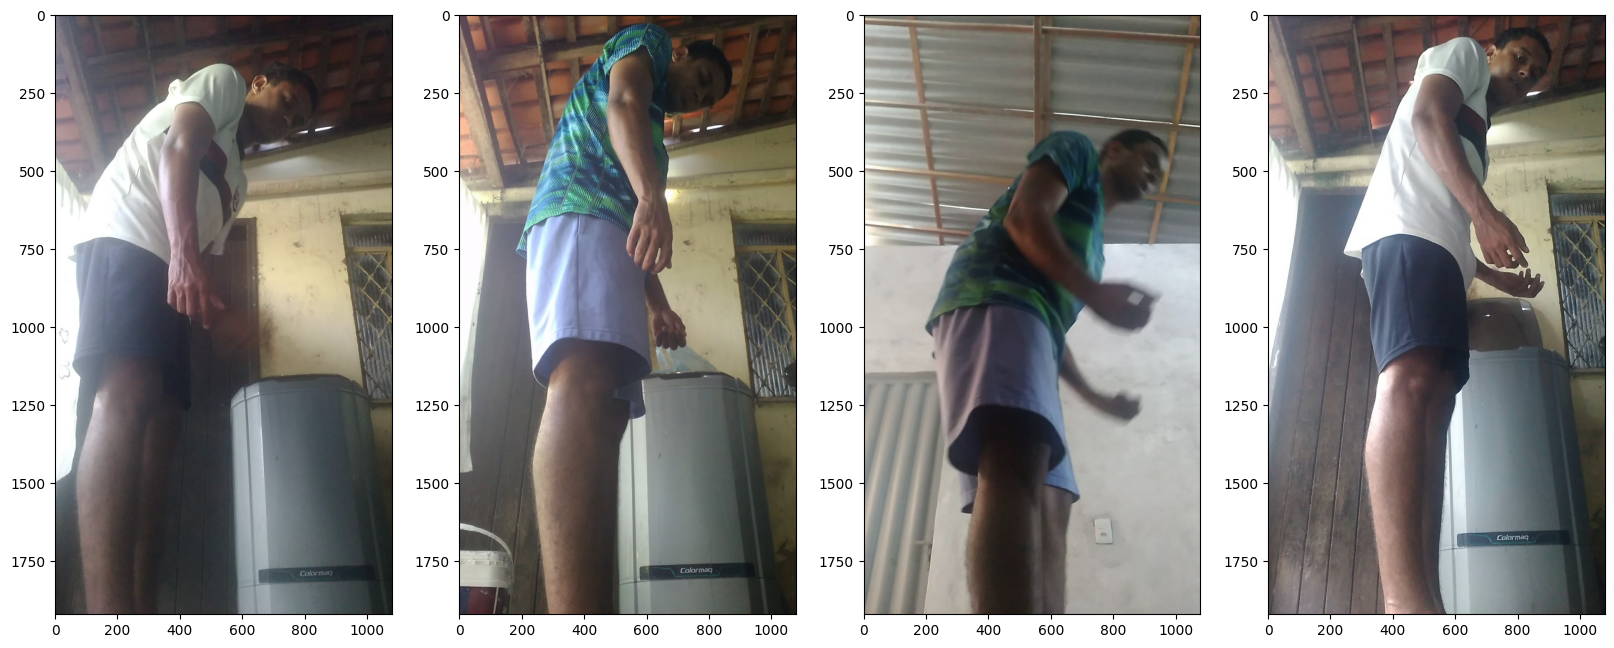

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(plot_images[i])
plt.show()

splits images

In [36]:
source_dir = 'data/columnU'

target_dir = 'data/columnU_split'

train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1

os.makedirs(os.path.join(target_dir, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val/images'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'test/images'), exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.endswith('.jpg'):
        source_path = os.path.join(source_dir, filename)
        rand = random.random()
        if rand < train_percentage:
            shutil.copy(source_path, os.path.join(target_dir, 'train/images', filename))
        elif rand < train_percentage + val_percentage:
            shutil.copy(source_path, os.path.join(target_dir, 'val/images', filename))
        else:
            shutil.copy(source_path, os.path.join(target_dir, 'test/images', filename))

In [46]:
for folder in ['train', 'val', 'test']:
    for file in os.listdir(os.path.join('data/columnU_split/', folder, 'images')):     
        filename = file.split('.')[0]+'.xml'
        existing_path = os.path.join('data/', 'labels', filename)
        if os.path.exists(existing_path):
            new_path = os.path.join('data/columnU_split/', folder, 'labels', filename)
            shutil.copy(existing_path, new_path)

entrei aqui if
data/columnU_split/train/labels/postureIncorrect_0.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_1.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_2.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_3.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_4.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_6.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_7.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_8.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_9.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_10.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_11.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_13.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_14.xml
entrei aqui if
data/columnU_split/train/labels/postureIncorrect_16.xml
entrei aqui if


In [47]:
import albumentations as alb

In [71]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [50]:
img = cv2.imread(os.path.join('data/columnU_split/train/images', 'postureIncorrect_0.jpg'))

In [72]:
with open(os.path.join('data/columnU_split/train/labels', 'postureIncorrect_0.xml')) as f:
    tree = ET.parse(f)
    root = tree.getroot()
    bboxes = []
    labels = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(obj.find('name').text)

In [86]:
coords = [0,0,0,0]
coords[0] = bboxes[0][0]
coords[1] = bboxes[0][1]
coords[2] = bboxes[0][2]
coords[3] = bboxes[0][3]
coords
labels

['U']

In [90]:
coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))

In [91]:
coords

[0.29444444444444445,
 0.09114583333333333,
 0.7870370370370371,
 0.41354166666666664]

In [92]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['U'])


In [95]:
augmented['image'].shape

(450, 450, 3)

In [96]:
cv2.rectangle(augmented['image'], (int(augmented['bboxes'][0][0]*augmented['image'].shape[1]),
                                      int(augmented['bboxes'][0][1]*augmented['image'].shape[0])),
                    (int(augmented['bboxes'][0][2]*augmented['image'].shape[1]),
                        int(augmented['bboxes'][0][3]*augmented['image'].shape[0])), (0, 255, 0), 2)
plt.imshow(augmented['image'])

array([[[213, 209, 204],
        [212, 208, 203],
        [212, 208, 203],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[212, 209, 204],
        [212, 209, 204],
        [212, 209, 204],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[212, 209, 204],
        [212, 209, 204],
        [212, 209, 204],
        ...,
        [100,  88,  70],
        [100,  88,  70],
        [  0, 255,   0]],

       ...,

       [[180, 179, 175],
        [180, 179, 175],
        [180, 179, 175],
        ...,
        [ 47,  52,  83],
        [ 48,  53,  84],
        [ 49,  54,  85]],

       [[180, 179, 175],
        [180, 179, 175],
        [180, 179, 175],
        ...,
        [ 46,  51,  82],
        [ 47,  52,  83],
        [ 49,  54,  85]],

       [[179, 178, 174],
        [179, 178, 174],
        [179, 178, 174],
        ...,
        [ 46,  51,  82],
        [ 47,  52,  83],
        [ 49,  54,  85]]